In [45]:
import os
import numpy as np
import random
import pickle
import copy
from matplotlib import pyplot as plt
from datetime import datetime
from itertools import combinations
import h5py

from scipy.stats import norm

np.random.seed(0)
random.seed(0)

In [2]:
new_num_kfolds = 7
NUM_CLIENTS = 14
local_round_threshold = 20
num_usuable_updates = 7

## Membership Inference Attack

In [12]:
with open(cv_results_path+f"\\{directory_str}\\membership_inference_results.pkl", 'rb') as f:
    membership_inference_results = pickle.load(f)

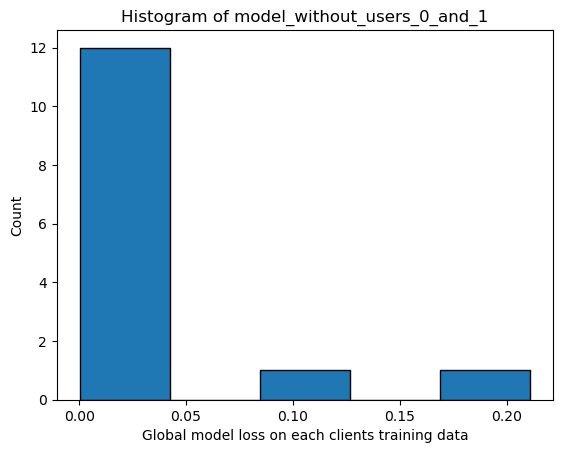

In [14]:
key0 = list(membership_inference_results.keys())[0]

plt.hist(membership_inference_results[key0], bins=5, edgecolor='black')
# Add labels and title
plt.xlabel('Global model loss on each clients training data')
plt.ylabel('Count')
plt.title('Histogram of model_without_users_0_and_1')
plt.show()

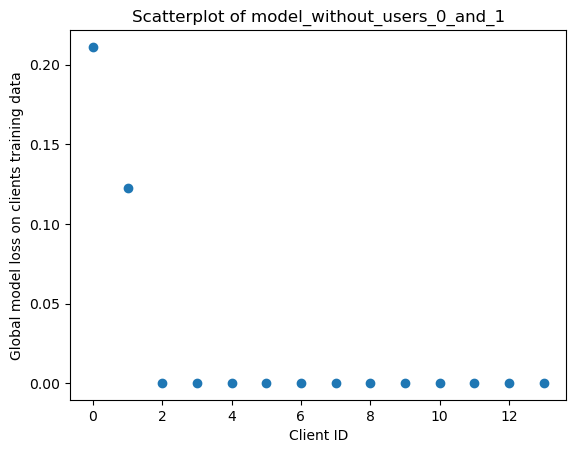

In [15]:
plt.scatter(range(len(membership_inference_results[key0])), membership_inference_results[key0])
plt.xlabel('Client ID')
plt.ylabel('Global model loss on clients training data')
plt.title('Scatterplot of model_without_users_0_and_1')
plt.show()

In [16]:
# Initialize an empty dictionary to store the new mappings
model_without_single_user_dict = {f"model_without_user_{i}": [] for i in range(NUM_CLIENTS)}  # For users 0 to 13

# Iterate through each key and its corresponding value in the original dictionary
for key, model_list in membership_inference_results.items():
    # Extract the user numbers from the key (format "model_without_users_X_and_Y")
    users_str = key.replace("model_without_users_", "")
    user_IDs = list(map(int, users_str.split('_and_')))

    # Add the model list to the new dictionary for both users
    for user in user_IDs:
        model_without_single_user_dict[f"model_without_user_{user}"].append(model_list)

# Optional: Remove duplicates in each list (if necessary)
#for key, model_list in new_dict.items():
#    new_dict[key] = list(set(model_list))  # Remove duplicates


In [28]:
len(model_without_single_user_dict['model_without_user_0'])

13

In [29]:
len(model_without_single_user_dict['model_without_user_0'][0])

14

In [18]:

# Initialize empty dictionaries to hold withheld and included losses
withheld_losses_dict = {}
included_losses_dict = {}

# Iterate through the dictionary to separate withheld and included user losses
for key, model_list in model_without_single_user_dict.items():
    # Extract the user number from the key (e.g., 'model_without_user_0')
    user_num = int(key.replace('model_without_user_', ''))
    
    # Initialize the lists for storing losses for this user
    withheld_user_losses = []
    included_user_losses = []
    
    # Iterate over each nested list in the model_list
    for model_losses in model_list:
        # Separate the withheld user's loss (e.g., the 0th element for user 0)
        withheld_user_losses.append(model_losses[user_num])
        
        # Separate the included users' losses (e.g., all elements except the 0th for user 0)
        included_user_losses.append([loss for idx, loss in enumerate(model_losses) if idx != user_num])
    
    # Store the separated losses in the corresponding dictionaries
    withheld_losses_dict[key] = withheld_user_losses
    included_losses_dict[key] = included_user_losses


In [20]:
withheld_losses_dict.keys()

dict_keys(['model_without_user_0', 'model_without_user_1', 'model_without_user_2', 'model_without_user_3', 'model_without_user_4', 'model_without_user_5', 'model_without_user_6', 'model_without_user_7', 'model_without_user_8', 'model_without_user_9', 'model_without_user_10', 'model_without_user_11', 'model_without_user_12', 'model_without_user_13'])

In [25]:
print(len(withheld_losses_dict['model_without_user_0']))
withheld_losses_dict['model_without_user_0']

13


[0.2111205,
 0.211437,
 0.2114938,
 0.2109569,
 0.2118821,
 0.2107758,
 0.21148,
 0.2113234,
 0.2111918,
 0.2113506,
 0.2116626,
 0.2116882,
 0.2113949]

In [22]:
included_losses_dict.keys()

dict_keys(['model_without_user_0', 'model_without_user_1', 'model_without_user_2', 'model_without_user_3', 'model_without_user_4', 'model_without_user_5', 'model_without_user_6', 'model_without_user_7', 'model_without_user_8', 'model_without_user_9', 'model_without_user_10', 'model_without_user_11', 'model_without_user_12', 'model_without_user_13'])

In [24]:
len(included_losses_dict['model_without_user_0'])

13

In [30]:
len(included_losses_dict['model_without_user_0'][0])

13

In [40]:
conf_obs = 0.8  # Example confidence score

# This is incorrect, would need to use the labels to convert each to a confidence BEFORE finding mean and var
included_losses_lst = [lst for lst in included_losses_dict['model_without_user_0']]
mu_in = np.mean(included_losses_lst)
sigma_in = np.var(included_losses_lst)

mu_out = np.mean(withheld_losses_dict['model_without_user_0'])
sigma_out = np.var(withheld_losses_dict['model_without_user_0'])

print(f"mu_in: {mu_in}")
print(f"sigma_in: {sigma_in}")
print(f"mu_out: {mu_out}")
print(f"sigma_out: {sigma_out}")

mu_in: 0.006542168639053255
sigma_in: 0.0009685213417182472
mu_out: 0.21136596923076922
sigma_out: 8.474733136094497e-08


In [65]:
def cost_l2(F, D, V, alphaD=1e-4, alphaE=1e-6, Nd=2, Ne=64, return_cost_func_comps=False):
    '''
    F: 64 channels x time EMG signals
    V: 2 x time target velocity
    D: 2 (x y vel) x 64 channels decoder
    H: 2 x 2 state transition matrix
    alphaE is 1e-6 for all conditions
    ''' 

    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    # Performance
    term1 = alphaE*(np.linalg.norm((D@F - Vplus))**2)
    # D Norm (Decoder Effort)
    term2 = alphaD*(np.linalg.norm(D)**2)
    # F Norm (User Effort)
    #term3 = alphaF*(np.linalg.norm(F)**2)
    if return_cost_func_comps:
        return (term1 + term2), term1, term2
    else:
        return (term1 + term2)

def logit(p):
    return np.log(p / (1 - p))

def compute_confidence(pred, true):
    # Compute confidence based on residuals (somewhat arbitrary metric/formula chosen)
    #In a regression setting, you could consider defining confidence in a similar way by scaling the residuals/errors into a probability-like value.
    #This would map higher errors (larger residuals) to lower confidence, and small errors to higher confidence (closer to 1).
    return np.exp(-np.abs(pred - true))  # Higher error -> lower confidence

In [94]:
# CROSS
user_pairs = list(combinations(range(NUM_CLIENTS), 2))
global_dec_dict = {f"without_user{i}": [] for i in range(NUM_CLIENTS)}
unique_global_dec_lst = []

cv_results_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results"
directory_str = "09-24_18-50_FEDAVG"

num_user_pairs = len(user_pairs)
for pair_idx, (user1, user2) in enumerate(user_pairs):
    #print(f"PAIR_IDX: {pair_idx}/{num_user_pairs}\nTraining models leaving out users {user1} and {user2}")
    fedavg_filename = f"GDLS_FEDAVG_model_without_users_{user1}_and_{user2}.h5" 
    #nofl_filename = "FULLSCIPYMIN_NOFL_KFold0.h5" 
    h5_path = os.path.join(cv_results_path, directory_str, fedavg_filename)

    with h5py.File(h5_path, 'r') as f:
        #a_group_key = list(f.keys())#[0]
        #print(a_group_key)
        #local_test_error_log = f['local_test_error_log'][()]
        #local_train_error_log = f['local_train_error_log'][()]
        #client_local_model_log_keys = list(f['client_local_model_log'].keys())
        #client_local_model_log_data = {}
        #for key in client_local_model_log_keys:
        #    try:
        #        client_local_model_log_data[key] = f['client_local_model_log'][key][:]
        #    except KeyError:
        #        pass
        #client_local_test_log_keys = list(f['client_local_test_log'].keys())
        # Iterate over the keys and extract the corresponding data
        #client_local_test_log_data = {}
        #for key in client_local_test_log_keys:
        #    client_local_test_log_data[key] = f['client_local_test_log'][key][:]
        #client_gradnorm_log_keys = list(f['gradient_norm_lists_by_client'].keys())
        # Iterate over the keys and extract the corresponding data
        #client_gradnorm_log_data = {}
        #for key in client_gradnorm_log_keys:
        #    client_gradnorm_log_data[key] = f['gradient_norm_lists_by_client'][key][:]
        if "FEDAVG" in directory_str:
            # CURRENTLY OVERWRITES INSTEAD OF APPENDS!
            #global_dec_dict[f'without_users_{user1}_and_{user2}'].append(f['global_dec_log'][()][-1])
            global_dec_dict[f'without_user{user1}'].append(f['global_dec_log'][()][-1])
            global_dec_dict[f'without_user{user2}'].append(f['global_dec_log'][()][-1])
            unique_global_dec_lst.append(f['global_dec_log'][()][-1])


In [91]:
global_dec_dict.keys()

dict_keys(['without_user0', 'without_user1', 'without_user2', 'without_user3', 'without_user4', 'without_user5', 'without_user6', 'without_user7', 'without_user8', 'without_user9', 'without_user10', 'without_user11', 'without_user12', 'without_user13'])

In [93]:
key0 = list(global_dec_dict.keys())[0]
len(global_dec_dict[key0])

13

In [95]:
len(unique_global_dec_lst)

91

In [165]:
path = r'C:\Users\kdmen\Desktop\Research\Data\CPHS_EMG'
model_saving_dir = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\models"
cond0_filename = r'\cond0_dict_list.p'

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]
STARTING_UPDATE = 10
starting_update_ix = update_ix[STARTING_UPDATE]
final_usable_update = 17
final_usable_update_ix = update_ix[final_usable_update]
adj_update_ix = np.array(update_ix[STARTING_UPDATE:final_usable_update]) - starting_update_ix
print(adj_update_ix)

client_data = dict()
client_labels = dict()
# Sets the full data and label sets for each client
for i in range(NUM_CLIENTS):
    client_data[i] = cond0_training_and_labels_lst[i]['training'][starting_update_ix:final_usable_update_ix, :]
    client_labels[i] = cond0_training_and_labels_lst[i]['labels'][starting_update_ix:final_usable_update_ix, :]
upper_bound = 1202+1
lower_bound = 0

# Need to edit each update so taht it is preprocessed (eg normalized, for PFA create 2 batches?)
## And need to divide each into updates, right now is just a full matrix
## Create F, v, p, etc? ... I think I'm only using F...

# Thus, everything is already partitioned into the updates of size 1202 for me, and the 7 folds

client_F_dict = dict()
client_pref_dict = dict()
client_V_dict = dict()
client_vactual_dict = dict()
client_loss_dict = dict()
client_conf_dict = dict()
for i in range(NUM_CLIENTS):
    client_dataset = client_data[i]
    client_labelset = client_labels[i]
    cli_F_lst = []
    cli_pref_lst = []
    cli_V_lst = []
    cli_vactual_lst = []
    cli_loss_lst = []
    cli_conf_lst = []

    chunk_size = 1202
    for j, data_idx in enumerate(range(0, len(client_dataset), chunk_size)): # j=7 I think
        #print(f"j: {j} of 7")
        s_temp = client_dataset[data_idx:data_idx + chunk_size]
        p_reference = np.transpose(client_labelset[data_idx:data_idx + chunk_size])
            
        s_normed = s_temp/np.amax(s_temp)
        s = np.transpose(s_normed)
        F = s[:,:-1] # note: truncate F for estimate_decoder

        cli_F_lst.append(F)
        cli_pref_lst.append(p_reference)
        for D_idx, D in enumerate(unique_global_dec_lst): # unique_global_dec_lst has len 91
            #print(f"D: {D_idx} of 91")
            # So this loops 7*91 = 637
            ## Probably don't need to test all 7 samples of F? Is the last F even included...
            
            v_actual = D@s
            #cli_vactual_lst.append(v_actual)
            p_actual = np.cumsum(v_actual, axis=1)*(1/60)  # Numerical integration of v_actual to get p_actual        
            V = (p_reference - p_actual)*(1/60)
            #loss = cost_l2(F, D, V, alphaE=1e-6, alphaD=1e-4, Ne=64)
            conf = compute_confidence(v_actual, V)
            
            cli_V_lst.append(V)
            #cli_loss_lst.append(loss)
            cli_conf_lst.append(conf)
    
    client_F_dict[i] = copy.deepcopy(cli_F_lst)
    client_pref_dict[i] = copy.deepcopy(cli_pref_lst)
    client_V_dict[i] = copy.deepcopy(cli_V_lst)  # OPTIMAL VELOCITY (TRUE LABEL)
    #client_vactual_dict[i] = copy.deepcopy(cli_vactual_lst)  # MODEL's OUTPUT VELOCITY
    #client_loss_dict[i] = copy.deepcopy(cli_loss_lst)
    client_conf_dict[i] = copy.deepcopy(cli_conf_lst)

[   0 1202 2404 3606 4808 6010 7212]


In [156]:
def calculate_model_output_and_Vlabel(model, input_F, label_pref):
    v_actual = model@F  # Originally this was s...
    p_actual = np.cumsum(v_actual, axis=1)*(1/60)  # Numerical integration of v_actual to get p_actual        
    V = (label_pref[:,:-1] - p_actual)*(1/60)  # [:,:-1] adjusts for using F instead of s, hopefully
    return v_actual, V

So each dict entry is for one client, and is all the corresponding data from said client
- I don't think I actually need F or V anymore, or frankly the loss
- Just need the confidence score

In [ ]:
#print(len(client_F_dict[0]))
#print(len(client_V_dict[0]))
#print(len(client_loss_dict[0]))
print(len(client_conf_dict[0]))

In [124]:
len(client_conf_dict[user_idx])

637

In [125]:
# Now I need to write out / map which global model was trained on which data
## The order is just the same order as user_pairs

# Then, separate all the entries of client_conf_dict[i] into models trained on client i and models not trained on client i

# Initialize a dictionary to store two lists for each user: one for models with the user, one without
user_models_separated_dict = {f'user_{i}': {'models_with_user': [], 'models_without_user': []} for i in range(NUM_CLIENTS)}
user_confs_separated_dict = {f'user_{i}': {'confs_with_user': [], 'confs_without_user': []} for i in range(NUM_CLIENTS)}
#user_model_separated_dict = {f'user_{i}': {'models_with_user': [], 'models_without_user': []} for i in NUM_CLIENTS}
#user_model_separated_dict = {f'user_{i}': {'models_with_user': [], 'models_without_user': []} for i in NUM_CLIENTS}

# Iterate over all users to distribute the models
for user_idx in range(NUM_CLIENTS): #14
    conf = client_conf_dict[user_idx]  # 14 user keys, each value is a list of 91 models * 7 input batches, thus 637 confs...
    ## So it is by user (NOT USER PAIR), and then by model idx
    ## But model idx is the same as user_pair idx?
    
    # Loop through the saved models and the corresponding user pairs
    for pair_idx, (user1_in_pair, user2_in_pair) in enumerate(user_pairs): # 91
        #model = saved_models[pair_idx]  # Access the model corresponding to this pair
        if user_idx in [user1_in_pair, user2_in_pair]:
            user_confs_separated_dict[f'user_{user_idx}']['confs_without_user'].extend(conf)
        else:
            user_confs_separated_dict[f'user_{user_idx}']['confs_with_user'].extend(conf)


In [126]:
user_confs_separated_dict.keys()

dict_keys(['user_0', 'user_1', 'user_2', 'user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_8', 'user_9', 'user_10', 'user_11', 'user_12', 'user_13'])

In [127]:
len(user_confs_separated_dict['user_0']['confs_with_user'])

49686

In [132]:
49686 / 637

78.0

In [133]:
len(user_confs_separated_dict['user_0']['confs_without_user'])

8281

In [135]:
user_confs_separated_dict['user_0']['confs_without_user'][0].shape

(2, 1202)

In [137]:
# STEP 1: Collect confidence scores from shadow models
# user0_confs_with_user
conf_in_lst = user_confs_separated_dict['user_0']['confs_with_user']
# user0_confs_without_user
conf_out_lst = user_confs_separated_dict['user_0']['confs_without_user']

In [138]:
# STEP 2: Apply logit transformation to confidences
logit_conf_in_lst = [logit(p) for p in conf_in_lst]
logit_conf_out_lst = [logit(p) for p in conf_out_lst]

In [145]:
# Not sure if this is correct since we really have batches of data/confidences, not single values...
## Thus can't create a histogram...
print(len(logit_conf_in_lst))
print(logit_conf_in_lst[0].shape)

49686
(2, 1202)


In [ ]:
# STEP 3: Fit Gaussian distributions (mean and variance)
mu_in, sigma_in = np.mean(logit_conf_in_lst), np.var(logit_conf_in_lst)
mu_out, sigma_out = np.mean(logit_conf_out_lst), np.var(logit_conf_out_lst)

In [ ]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\Prelim_Sim_Results_V2'
base_path = results_path + current_directory

# CROSS
cross_pfa, cross_pfa_client_final_loss_fold_logs_lst = load_final_model_performaces(base_path+r'\08-23_21-20_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5', type="CROSS")
cross_fedavg, cross_fedavg_client_final_loss_fold_logs_lst = load_final_model_performaces(base_path+r'\08-23_22-17_FEDAVG', 'GDLS_FEDAVG_CrossValResults.h5', type="CROSS")
cross_nofl, cross_nofl_client_final_loss_fold_logs_lst = load_final_model_performaces(base_path+r'\08-23_22-18_NOFL', 'FULLSCIPYMIN_NOFL_CrossValResults.h5', type="CROSS")

In [150]:
cv_results_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\FinalSims"
#nofl_filename = "FULLSCIPYMIN_NOFL_KFold0.h5" 
fedavg_filename = "GDLS_FEDAVG_KFold0.h5" 
directory_str = "09-20_15-34_FEDAVG"
h5_path = os.path.join(cv_results_path, directory_str, fedavg_filename)

with h5py.File(h5_path, 'r') as f:
    # I don't need this yet, probably will later tho...
    #client_local_model_log_keys = list(f['client_local_model_log'].keys())
    #client_local_model_log_data = {}
    #for key in client_local_model_log_keys:
    #    try:
    #        client_local_model_log_data[key] = f['client_local_model_log'][key][:]
    #    except KeyError:
    #        pass

    if "FEDAVG" in directory_str:
        FinalSims_FEDAVG_KFold0_GlobalModelLog = f['global_dec_log'][()]
        FinalSims_FEDAVG_KFold0_GlobalModel = FinalSims_FEDAVG_KFold0_GlobalModelLog[-1]


In [151]:
FinalSims_FEDAVG_KFold0_GlobalModelLog.shape

(251, 2, 64)

In [158]:
FinalSims_FEDAVG_KFold0_GlobalModel.shape

(2, 64)

In [163]:
client_F_dict[0][0].shape

(64, 1201)

In [162]:
client_pref_dict[0][0].shape

(1202,)

In [166]:
target_pred, true_label = calculate_model_output_and_Vlabel(FinalSims_FEDAVG_KFold0_GlobalModel, client_F_dict[0][0], client_pref_dict[0][0])

In [178]:
print(target_pred.shape)
print(true_label.shape)

(2, 1201)
(2, 1201)


In [169]:
# STEP 4: Query the target model on (x, y) to get its prediction and compute confidence
conf_obs = compute_confidence(target_pred, true_label)  # compute confidence for the target model
logit_conf_obs = logit(conf_obs)  # apply logit scaling

In [175]:
print(logit_conf_obs.shape)  # --> Shape is (2, 12)

(2, 1201)

In [180]:
# Assuming target_pred and true_label are (2, 1201) as in your example
# Step 4: Compute confidence across all time points
# Let's take the mean confidence for each of x and y (dimension 0)
conf_obs_x = compute_confidence(target_pred[0, :], true_label[0, :])  # Confidence for x-direction
conf_obs_y = compute_confidence(target_pred[1, :], true_label[1, :])  # Confidence for y-direction

# Now, aggregate the confidence over the time dimension (1201 time points)
# You can try mean, median, max, or other summary statistics. Here, I will use the mean
conf_obs_x_agg = np.mean(conf_obs_x)  # Aggregate over the time points for the x direction
conf_obs_y_agg = np.mean(conf_obs_y)  # Aggregate over the time points for the y direction

# Apply logit scaling to the aggregated confidence scores
logit_conf_obs_x = logit(conf_obs_x_agg)
logit_conf_obs_y = logit(conf_obs_y_agg)

# Perform the likelihood-ratio test for each dimension separately
p_in_x = norm.pdf(logit_conf_obs_x, mu_in, sigma_in)
p_out_x = norm.pdf(logit_conf_obs_x, mu_out, sigma_out)

p_in_y = norm.pdf(logit_conf_obs_y, mu_in, sigma_in)
p_out_y = norm.pdf(logit_conf_obs_y, mu_out, sigma_out)

# Compute likelihood ratios for both x and y dimensions
likelihood_ratio_x = p_in_x / p_out_x
likelihood_ratio_y = p_in_y / p_out_y

# You could combine the likelihood ratios if needed, for example by averaging
likelihood_ratio = (likelihood_ratio_x + likelihood_ratio_y) / 2

print(f"Likelihood Ratio (X): {likelihood_ratio_x}")
print(f"Likelihood Ratio (Y): {likelihood_ratio_y}")
print(f"Combined Likelihood Ratio: {likelihood_ratio}")


Likelihood Ratio (X): nan
Likelihood Ratio (Y): nan
Combined Likelihood Ratio: nan


C:\Users\kdmen\AppData\Local\Temp\ipykernel_14080\4021917254.py:24: RuntimeWarning: invalid value encountered in scalar divide
  likelihood_ratio_x = p_in_x / p_out_x
C:\Users\kdmen\AppData\Local\Temp\ipykernel_14080\4021917254.py:25: RuntimeWarning: invalid value encountered in scalar divide
  likelihood_ratio_y = p_in_y / p_out_y


In [181]:
p_in_x

0.0

In [182]:
p_out_x

0.0

In [183]:
logit_conf_obs_y

1.6654360858901547

In [184]:
mu_in

0.006542168639053255

In [185]:
mu_out

0.21136596923076922

In [186]:
conf_obs_x_agg

0.7415857308539022

In [187]:
logit_conf_obs_x

1.0542267815014503

In [171]:
# STEP 5: Perform likelihood-ratio test
p_in = norm.pdf(logit_conf_obs, mu_in, sigma_in)
p_out = norm.pdf(logit_conf_obs, mu_out, sigma_out)

In [172]:
p_in

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [173]:
p_out

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
likelihood_ratio = p_in / p_out

print(f"Likelihood Ratio: {likelihood_ratio}")

In [ ]:
def run_membership_inference_attack(user_confs_separated_dict, ):
    # STEP 1: Collect confidence scores from shadow models
    # user0_confs_with_user
    conf_in_lst = user_confs_separated_dict['user_0']['confs_with_user']
    # user0_confs_without_user
    conf_out_lst = user_confs_separated_dict['user_0']['confs_without_user']
    
    # STEP 2: Apply logit transformation to confidences
    logit_conf_in_lst = [logit(p) for p in conf_in_lst]
    logit_conf_out_lst = [logit(p) for p in conf_out_lst]
    
    # STEP 3: Fit Gaussian distributions (mean and variance)
    mu_in, sigma_in = np.mean(logit_conf_in_lst), np.var(logit_conf_in_lst)
    mu_out, sigma_out = np.mean(logit_conf_out_lst), np.var(logit_conf_out_lst)
    
    # STEP 4: Query the target model on (x, y) to get its prediction and compute confidence
    # THIS NEEDS TO BE UPDATED
    conf_obs = compute_confidence(target_pred, true_label)  # compute confidence for the target model
    logit_conf_obs = logit(conf_obs)  # apply logit scaling
    
    # STEP 5: Perform likelihood-ratio test
    p_in = norm.pdf(logit_conf_obs, mu_in, sigma_in)
    p_out = norm.pdf(logit_conf_obs, mu_out, sigma_out)
    likelihood_ratio = p_in / p_out
    
    print(f"Likelihood Ratio: {likelihood_ratio}")

How to make MIA work for my FL case <br>
Also for Local... allegedly, between INTRA and CROSS, the local models should actually be the same (as long as the model didn't advance all the way to the final updates where the cut is in INTRA, although that probably happened, although is likely a miniscule effect). So this approach would then allow me to tell from what user the local model came from. So presumably, Local will have good defense against interception based attacks (eg ones that use model weights to classify models to users) but will get BTFOd by membership inference attacks. MIA is ofc a much more involved attack.

## Mutual Information

In [9]:
# Not used right now. Probably also out of date

# INTRA
'09-19_22-56_NOFL'
'09-19_23-04_FEDAVG' 
'09-19_23-05_PFAFO_GDLS'

# CROSS
'09-19_23-07_PFAFO_GDLS'
'09-19_23-25_FEDAVG'
'09-19_23-30_NOFL'

# This is for the mutual info stuff really...

cv_results_path = r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\FinalSims"
nofl_filename = "FULLSCIPYMIN_NOFL_KFold0.h5" 
fedavg_filename = "GDLS_FEDAVG_KFold0.h5" 

directory_str = "09-19_23-25_FEDAVG"
h5_path = os.path.join(cv_results_path, directory_str, fedavg_filename)

# This is also not used right now, I don't think?

if False:
    with h5py.File(h5_path, 'r') as f:
        a_group_key = list(f.keys())#[0]
        print(a_group_key)
    
        local_test_error_log = f['local_test_error_log'][()]
        local_train_error_log = f['local_train_error_log'][()]
        
        client_local_model_log_keys = list(f['client_local_model_log'].keys())
        #print("Keys in 'client_local_test_log':", client_local_model_log_keys)
        client_local_model_log_data = {}
        for key in client_local_model_log_keys:
            try:
                client_local_model_log_data[key] = f['client_local_model_log'][key][:]
            except KeyError:
                pass
                
        client_local_test_log_keys = list(f['client_local_test_log'].keys())
        # Iterate over the keys and extract the corresponding data
        client_local_test_log_data = {}
        for key in client_local_test_log_keys:
            client_local_test_log_data[key] = f['client_local_test_log'][key][:]
    
        client_gradnorm_log_keys = list(f['gradient_norm_lists_by_client'].keys())
        # Iterate over the keys and extract the corresponding data
        client_gradnorm_log_data = {}
        for key in client_gradnorm_log_keys:
            client_gradnorm_log_data[key] = f['gradient_norm_lists_by_client'][key][:]
    
        if "FEDAVG" in directory_str:
            global_dec_log = f['global_dec_log'][()]

if False:
    print(client_local_model_log_keys)
    print()
    for i in range(NUM_CLIENTS):
        print(client_local_model_log_data[client_local_model_log_keys[i]].shape)
    print()
    print(global_dec_log.shape)

#from sklearn.neighbors import KernelDensity
#from sklearn.metrics import mutual_info_score
#import numpy as np
#from sklearn.decomposition import PCA
#from sklearn.feature_selection import mutual_info_regression

if False:
    # Find the longest array based on shape[0]
    max_length = max(client_local_model_log_data[key].shape[0] for key in client_local_model_log_keys)
    # Generate the indices for equally spaced sampling from global_dec_log
    indices = np.linspace(0, len(global_dec_log) - 1, max_length).astype(int)
    # Sample global_dec_log to match the length of the longest client array
    sampled_global_dec_log = global_dec_log[indices]

    # So now I need to link each set of 20 consecutive models to each update. Eg 1-20-->F1, 21-40-->F2, ... 140+-->F7 (might not get to F7!)
    ## So it should iterative through consecutive models
    
    # THIS PART DOESNT WORK: MI ISNT DEFINED / WORK WELL BETWEEN TRAINING DATA AND WEIGHTS, APPARENTLY...
    ## Maybe I could just ignore that and flatten the model weights and it would be fine? Not sure...
    cli_mi_local = {i: [] for i in range(NUM_CLIENTS)}
    cli_mi_global = {i: [] for i in range(NUM_CLIENTS)}
    for i in range(NUM_CLIENTS):
        cli_i_model_log = client_local_model_log_data[client_local_model_log_keys[i]]
        if cli_i_model_log.shape[0]<2:
            # Client didnt train (eg it was probably a testset client)
            print(f"Cli {i} skipped for being too short!")
        else:
            for model_idx, model in enumerate(cli_i_model_log):
                # Models and dataset may not be aligned
                ## Eg some may be saved in order of 0, 10, 11, 12, 13, 1, ... whereas the other may be saved as 0, 1, 2, 3, ...
    
                if model_idx > local_round_threshold * num_usuable_updates:
                    input_index = 7
                else:
                    input_index = model_idx // local_round_threshold
                # Access the corresponding input for this chunk
                X_train = client_F_dict[i][input_index]  # TODO: THIS DOES NOT SUPPORT 2 BATCH PFA RIGHT NOW!
                #print(f"Model idx: {model_idx}; Update (input) index: {input_index}'")
    
                # COMPARE EACH LOCAL MODEL TO THE TRAINING DATA TO GENERATE A MUTUAL INFORMATION CURVE
                # Step 1: Dimensionality reduction of training data using PCA
                # Reduce X_train to 2 dimensions to match model weights shape
                pca = PCA(n_components=2)
                X_train_PCA = pca.fit_transform(X_train).flatten()
                
                # Step 2: Compute mutual information between reduced training data and local model weights
                cli_mi_local[i].append(mutual_info_regression(X_train_PCA, model.flatten()))
                
                # COMPARE EACH GLOBAL MODEL (from the adjusted list) TO THE TRAINING DATA
                #if model_idx%20==0:
                cli_mi_global.append(mutual_info_regression(X_train_PCA, sampled_global_dec_log[model_idx].flatten()))

if False:
    # Helper function to compute entropy using KDE
    def kde_entropy(X, bandwidth=1.0):
        kde = KernelDensity(bandwidth=bandwidth)
        kde.fit(X)
        log_density = kde.score_samples(X)
        return -np.mean(log_density)
    
    # Helper function to compute mutual information using KDE
    def kde_mutual_information(X, Y, bandwidth=1.0):
        # Joint entropy H(X,Y)
        XY = np.hstack([X, Y])
        joint_entropy = kde_entropy(XY, bandwidth)
        
        # Marginal entropies H(X) and H(Y)
        entropy_X = kde_entropy(X, bandwidth)
        entropy_Y = kde_entropy(Y, bandwidth)
        
        # MI = H(X) + H(Y) - H(X,Y)
        mutual_info = entropy_X + entropy_Y - joint_entropy
        return mutual_info
    
    # Dummy training data (64 examples, 1202 features)
    X_train = np.random.rand(64, 1202)
    
    # Dummy local model weights (64 examples, 2 features)
    client_local_model_weights = np.random.rand(64, 2)
    
    # Dummy global model weights (64 examples, 2 features)
    global_model_weights = np.random.rand(64, 2)
    
    # Step 1: Reduce the training data dimensionality using PCA to match model weights (optional, depending on your scenario)
    # Alternatively, you can use summary statistics, but let's use PCA here for KDE method
    pca = PCA(n_components=2)
    X_train_reduced = pca.fit_transform(X_train)
    
    # Step 2: Compute KDE-based mutual information between reduced training data and local model weights
    mi_local_kde = kde_mutual_information(X_train_reduced, client_local_model_weights)
    
    # Step 3: Compute KDE-based mutual information between reduced training data and global model weights
    mi_global_kde = kde_mutual_information(X_train_reduced, global_model_weights)
    
    # Output mutual information scores
    print("KDE-based Mutual Information between X_train and local model weights:", mi_local_kde)
    print("KDE-based Mutual Information between X_train and global model weights:", mi_global_kde)


## Model Inversion Attack

In [ ]:
if False:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    
    # Function to perform model inversion attack
    def model_inversion_attack(model, target_output, input_shape, num_iterations=1000, learning_rate=1e-2):
        # Initialize input (with random noise)
        inverted_input = torch.randn(input_shape, requires_grad=True)
        optimizer = optim.Adam([inverted_input], lr=learning_rate)
        
        loss_fn = nn.MSELoss()
        
        for i in range(num_iterations):
            optimizer.zero_grad()
            output = model(inverted_input)
            loss = loss_fn(output, target_output)
            loss.backward()
            optimizer.step()
        
        return inverted_input.detach()
    
    # Example usage
    client_models = [ClientModel() for _ in range(14)]  # Placeholder for client models
    target_model = client_models[0]  # Assume you are attacking the first client
    target_output = torch.tensor([0.1, 0.9])  # Target output we want to reproduce
    
    # Perform inversion attack to get reconstructed input
    inverted_input = model_inversion_attack(target_model, target_output, input_shape=(1, 28, 28))  # Example input shape (e.g. for images)
    print("Reconstructed input:", inverted_input)


In [ ]:
# Gradient Descent Model Inversion Attack on a Linear Regression Model
def model_inversion_attack(weights, target_output, input_shape, num_iterations=1000, learning_rate=0.01):
    # Initialize a random input (e.g., random noise)
    inverted_input = np.random.randn(*input_shape)
    
    for i in range(num_iterations):
        # Compute the output from the current inverted input
        output = np.dot(inverted_input, weights)
        
        # Compute the loss (Mean Squared Error between target and current output)
        loss = np.mean((output - target_output) ** 2)
        
        # Compute gradient of the loss with respect to the input
        grad = 2 * np.dot((output - target_output), weights.T) / len(target_output)
        
        # Update the inverted input by moving in the direction of the negative gradient
        inverted_input -= learning_rate * grad
        
        if i % 100 == 0:  # Print loss every 100 iterations
            print(f"Iteration {i}, Loss: {loss}")
    
    return inverted_input

# Example usage:
np.random.seed(42)

# Assume a simple linear regression model (2 features, 1 target)
weights = np.array([[2.0, -1.0]]).T  # A 2x1 weight matrix

# Target output we want to reproduce
target_output = np.array([0.5])

# Perform the model inversion attack to find an input that reproduces the target output
inverted_input = model_inversion_attack(weights, target_output, input_shape=(1, 2), num_iterations=1000, learning_rate=0.01)

print("Reconstructed input:", inverted_input)
